In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch.utils.data

from collections import Counter

from fastai.vision import *
from fastai.metrics import error_rate, fbeta

from tqdm import tqdm

In [3]:
path = Path('/media/chases/6CACED15ACECDA9A/data/chest_xray')
path.ls()

[PosixPath('/media/chases/6CACED15ACECDA9A/data/chest_xray/.DS_Store'),
 PosixPath('/media/chases/6CACED15ACECDA9A/data/chest_xray/models'),
 PosixPath('/media/chases/6CACED15ACECDA9A/data/chest_xray/test'),
 PosixPath('/media/chases/6CACED15ACECDA9A/data/chest_xray/train'),
 PosixPath('/media/chases/6CACED15ACECDA9A/data/chest_xray/val')]

In [4]:
assert all((path / folder).exists() for folder in ('train', 'val', 'test'))

In [5]:
!ls {path / 'train' / 'PNEUMONIA'} | wc -l

3875


In [6]:
!ls {path / 'train' / 'NORMAL'} | wc -l

1341


In [7]:
# Fast AI's fbeta function wants onehot Y values

def onehot(tensor:Tensor, n_classes=2): # default n_classes = 2 for ['NORMAL', 'PNEUMONIA']
    batch_size = tensor.shape[0]
    y = torch.zeros(batch_size, n_classes)
    y[range(batch_size), tensor.long()]=1
    return y.to(tensor.device) # use the same device as the input

In [8]:
def f2(y_pred: Tensor, y_true: Tensor) -> Rank0Tensor:
    return fbeta(y_pred, onehot(y_true), beta=2)

ImbalancedSampler is based on https://github.com/ufoym/imbalanced-dataset-sampler

In [9]:
class ImbalancedSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset):
        self.indices = list(range(len(dataset)))
        self.num_samples = len(dataset)
        
        labels = [str(dataset[idx][1]) for idx in tqdm(self.indices)]
            
        # distribution of classes in the dataset 
        label_to_count = Counter(labels)
                
        # weight for each sample
        weights = [1.0 / label_to_count[label] for idx, label in zip(self.indices, labels)]
        self.weights = torch.DoubleTensor(weights)
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [10]:
bs=128
tfms = get_transforms()
metrics=[error_rate, f2]

In [11]:
src = (ImageList.from_folder(path)
                .split_by_folder(valid='test')
                .label_from_folder())

In [10]:
data = (src.transform(tfms, size=256)
           .databunch(bs=bs, sampler=ImbalancedSampler))

100%|██████████| 5216/5216 [02:53<00:00, 30.08it/s]


In [11]:
data.train_dl.dl.sampler

In [ ]:
data.train_dl??

### Training

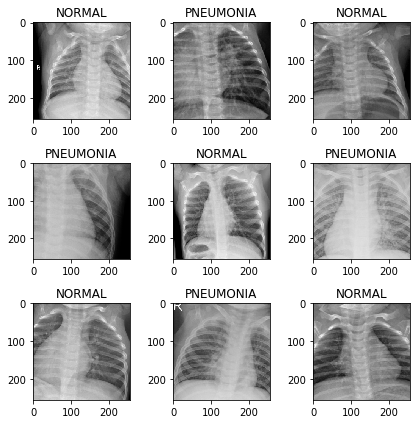

In [24]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

### Valid

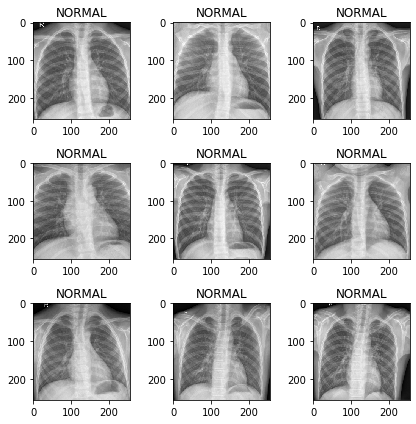

In [25]:
data.show_batch(3, figsize=(6,6), hide_axis=False, ds_type=DatasetType.Valid) # valid isn't shuffled

In [12]:
# sanity check
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['NORMAL', 'PNEUMONIA'], 2, 5216, 624)

In [ ]:
??cnn_learner

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=metrics)

learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


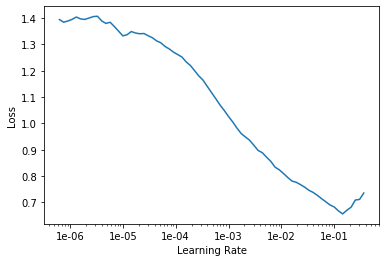

In [15]:
learn.recorder.plot()

In [16]:
lr=1e-2
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,error_rate,f2,time
0,0.317628,4.764690,0.368590,0.642361,01:54
1,0.197023,0.646048,0.198718,0.836004,01:53
2,0.134493,0.267522,0.092949,0.935096,01:51
3,0.095656,0.240176,0.072115,0.946314,01:54


In [17]:
learn.save('sz_256-stage1')

In [12]:
bs=32
size=512

data = (src.transform(tfms, size=size)
           .databunch(bs=bs, sampler=ImbalancedSampler))

100%|██████████| 5216/5216 [04:25<00:00, 18.56it/s]


In [13]:
learn = cnn_learner(data, models.resnet34, metrics=metrics)

In [14]:
learn.load('sz_256-stage1');

In [18]:
lr=3e-3
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,error_rate,f2,time
0,0.145352,0.350970,0.110577,0.926282,03:04
1,0.107896,0.252163,0.073718,0.933761,03:04
2,0.088126,0.218460,0.070513,0.944979,03:03
3,0.069588,0.311737,0.083333,0.935363,03:03


In [20]:
learn.save('sz_512-stage1-before-unfreeze')